# **Introduction**

The same idea with Part 3.11. However, this notebook has a leaner structure with a focus on normal time. It incorporated feature engineering/selection results with clustering algorithms and reached a more sensible number and assignment of clusters for the evictoins in the city.

In [1]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# !pip install geopandas contextily
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio
import contextily as ctx
from scipy.stats import f_oneway
from sklearn.decomposition import PCA

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# **Step 1 Get the Eviction data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data source:
link1 = "/content/drive/My Drive/X999/bbl_evictions_311_svi_normal_times_analysis.csv"
link2 = "/content/drive/My Drive/X999/bbl_evictions_311_svi_covid.csv"

In [ ]:
evictions_pre_post_raw = pd.read_csv(link1)
evictions_covid_raw = pd.read_csv(link2)
evictions_covid_raw.shape, evictions_pre_post_raw.shape
# 91 and 102.
# sometimes, it does take extra time and a new runtime for drive to return the updated file.

((5386, 91), (66397, 102))

In [ ]:
evictions_pre_post = evictions_pre_post_raw.copy()
evictions_covid = evictions_covid_raw.copy()

In [ ]:
evictions_pre_post.head(2)

,Unnamed: 0,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,nta,year,month_year,geometry,average_year_eviction_count,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,building_age,style_ordinal,style_freq,style_label,building_category_ordinal,building_category_freq,building_category_le,age_bin,age_group
0,0,*308072/22_5865,3037420029,*308072/22,5865,356 MILLER AVE,1 AND BASEMENT,2024-12-04,BROOKLYN,11207,Not an Ejectment,Possession,40.6721,-73.8911,5.0000,37.0000,1152.0000,3083989,East New York,2024,2024-12,POINT (-73.891105 40.672121),0.8000,1930.0000,C0,3.0000,3.0000,356 MILLER LLC,2700.0000,0,walk-up,0,1,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","1930-1945, great depression and WWII",4,1,3,3,1930-1939,11207,96801.0000,0.9788,0.9140,0.9808,0.9812,0.9839,33.9000,11.1000,19.1000,6.0000,13.8000,22.5000,13.8000,5.3000,57.8000,9.1000,44.7000,55.9000,32.8000,1.5000,0.0000,0.0000,2.9000,1.6000,94.7000,5.3000,False,Q3,medium-high,0.0000,0.0000,1.0000,0.0000,1.0000,2.0000,0.0000,0.0000,1.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.0000,3.0000,5.0000,19.0000,95.0000,3,0.2861,1,3,0.4125,5,50+,"(90, 120]"
1,1,*313639/23_5202,3057940012,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,40.6359,-74.0119,7.0000,38.0000,118.0000,3143881,Sunset Park East,2024,2024-03,POINT (-74.011883 40.635941),0.6000,1920.0000,B2,2.0000,2.0000,"A.R.M. PARKING, LLC",1204.0000,0,two-family,0,1,"Pre-1947, pre-rent-control","1900–1920, Beaux-Arts","Pre-1929, pre-great depression",2,1,2,1,1920-1929,11220,93008.0000,0.9885,0.7635,0.9594,0.9179,0.9662,37.5000,7.5000,37.9000,11.6000,13.1000,25.4000,8.4000,40.2000,61.7000,23.7000,43.6000,1.7000,40.9000,40.7000,0.4000,0.0000,1.2000,0.2000,85.0000,15.0000,False,Q3,medium-high,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,4.0000,105.0000,2,0.2298,0,2,0.0900,4,NaN,"(90, 120]"


In [ ]:
evictions_covid.head(2)

,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,nta,year,month_year,geometry,average_year_eviction_count,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints
0,004123/20_209969,2032140141,004123/20,209969,2541 A GRAND AVE,ROOM 3B,2022-08-22,BRONX,10468,Not an Ejectment,Possession,40.8654,-73.9013,7.0000,14.0000,265.0000,2113173,Kingsbridge Heights,2022,2022-08,POINT (-73.901317 40.865396),0.2000,2004.0000,C0,3.0000,3.0000,MONJU SARKER,3420.0000,post-war,walk-up,False,low-rise,"1994–Present, vacancy decontrol","2001-present, New Architecture","1991–2008, modern economic growth",3-5 units,False,medium-small,Q4 (largest 25%),2000-2009,10468,81397.0000,0.9954,0.9407,0.9870,0.9470,0.9874,39.5000,11.6000,28.3000,9.2000,11.2000,26.4000,12.2000,26.9000,71.8000,19.2000,56.7000,15.6000,78.0000,2.3000,0.0000,0.0000,0.5000,0.5000,96.9000,3.1000,False,Q3,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,2.0000,0.0000,0.0000,1.0000,0.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,3.0000,1.0000,14.0000
1,0050153/20_106030,4031560133,0050153/20,106030,98-05 67TH AVENUE,12F,2022-04-14,QUEENS,11375,Not an Ejectment,Possession,40.7242,-73.8556,6.0000,29.0000,71306.0000,4074666,Forest Hills,2022,2022-04,POINT (-73.855552 40.724241),0.2000,1960.0000,D3,13.0000,181.0000,MARSEILLES LEASING LIMITED PARTNERSHIP,177710.0000,post-war,elevator,False,high-rise,"1947–1969, rent-control","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),1960-1969,11375,75212.0000,0.4759,0.5698,0.8789,0.8057,0.7322,12.0000,4.8000,6.1000,3.7000,20.4000,18.0000,10.5000,7.9000,41.9000,5.8000,25.4000,2.7000,16.4000,28.5000,0.1000,0.0000,4.6000,0.7000,53.0000,47.0000,False,Q1 (Low),0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,62.0000,0.0000,34.0000,0.0000,0.0000,4.0000,1.0000,0.0000,0.0000,2.0000,5.0000,112.0000


In [ ]:
evictions_pre_post.columns, \
evictions_covid.columns, \
evictions_pre_post.shape, \
evictions_covid.shape

(Index(['Unnamed: 0', 'primary_key', 'bbl', 'court_index_number',
        'docket_number', 'eviction_address', 'eviction_apartment_number',
        'executed_date', 'borough', 'zipcode',
        ...
        'total_complaints', 'building_age', 'style_ordinal', 'style_freq',
        'style_label', 'building_category_ordinal', 'building_category_freq',
        'building_category_le', 'age_bin', 'age_group'],
       dtype='object', length=102),
 Index(['primary_key', 'bbl', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'zipcode', 'ejectment', 'eviction/legal_possession',
        'latitude', 'longitude', 'community_board', 'council_district',
        'census_tract', 'bin', 'nta', 'year', 'month_year', 'geometry',
        'average_year_eviction_count', 'yearbuilt', 'bldgclass', 'numfloors',
        'unitsres', 'ownername', 'bldgarea', 'building_type',
        'building_category', 'is_condo', 'floor_category

### Skipped these sections and subsections (see notebook part 1)

# **Step 2 DBSCAN and its limitations**

- Density-based spatial clustering of applications with noise (DBSCAN) is a clustering algorithm used in machine learning to partition data into clusters based on their distance to other points. Its effective at identifying and removing noise in a data set, making it useful for data cleaning and outlier detection.

##### https://builtin.com/articles/dbscan#:~:text=What%20Is%20DBSCAN%3F,their%20distance%20to%20other%20points.
##### https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data

### Prepare the data for DBSCAN test

- Why didn't log the average eviction data points first?

- We have tried log it first before send the data for further processing, but it only yields one cluster. Therefore logging it just compress the data too much and therefore it is not a good way to process the data in this case

- We chose DBSCAN here, because it does not presumbly ask for the number of clusters, whereas K means does. K means also assume the clusters are in circular form, which may not be the case with geo data

In [ ]:
evictions_covid.columns.tolist()

['primary_key',
 'bbl',
 'court_index_number',
 'docket_number',
 'eviction_address',
 'eviction_apartment_number',
 'executed_date',
 'borough',
 'zipcode',
 'ejectment',
 'eviction/legal_possession',
 'latitude',
 'longitude',
 'community_board',
 'council_district',
 'census_tract',
 'bin',
 'nta',
 'year',
 'month_year',
 'geometry',
 'average_year_eviction_count',
 'yearbuilt',
 'bldgclass',
 'numfloors',
 'unitsres',
 'ownername',
 'bldgarea',
 'building_type',
 'building_category',
 'is_condo',
 'floor_category',
 'rent_era',
 'architectural_style',
 'economic_period',
 'residential_units_category',
 'is_llc',
 'building_size_category',
 'size_quartile',
 'decade',
 'fips',
 'e_totpop',
 'rpl_theme1',
 'rpl_theme2',
 'rpl_theme3',
 'rpl_theme4',
 'rpl_themes',
 'ep_pov150',
 'ep_unemp',
 'ep_nohsdp',
 'ep_uninsur',
 'ep_age65',
 'ep_age17',
 'ep_disabl',
 'ep_limeng',
 'ep_noveh',
 'ep_crowd',
 'ep_hburd',
 'ep_afam',
 'ep_hisp',
 'ep_asian',
 'ep_aian',
 'ep_nhpi',
 'ep_twomore

## **Step 2.1: Get the elbow index**

Elbow index is derived from k-distance graph. it is the point where the radius of clustering makes sense. Will use it to find eps in dbscan.

In [ ]:
eviction_pre_post_counts = evictions_pre_post[['average_year_eviction_count','building_age', 'unitsres', 'plumbing_issues', 'total_complaints', 'bldgarea', 'appliances', 'doors_windows',
 'sanitation_issues', 'latitude', 'numfloors', 'noise_complaints', 'floors_stairs', 'longitude', 'ep_nohsdp', 'general_complaints',
 'ep_afam', 'heat_hot_water', 'walls_ceilings', 'ep_limeng', 'pest_issues']]

In [ ]:
scaler = StandardScaler()
# eviction_covid_scaled = scaler.fit_transform(eviction_covid_counts)
eviction_pre_post_scaled = scaler.fit_transform(eviction_pre_post_counts)

In [ ]:
len(['average_year_eviction_count','building_age', 'unitsres', 'plumbing_issues', 'total_complaints', 'bldgarea', 'appliances', 'doors_windows',
 'sanitation_issues', 'latitude', 'numfloors', 'noise_complaints', 'floors_stairs', 'longitude', 'ep_nohsdp', 'general_complaints',
 'ep_afam', 'heat_hot_water', 'walls_ceilings', 'ep_limeng', 'pest_issues'])

21

## **Step 2.2 Normal times**

In [ ]:
neighbor = NearestNeighbors(n_neighbors=2)
# 2, because the closest neighbor is itself.
nbrs = neighbor.fit(eviction_pre_post_scaled)
distances, _ = nbrs.kneighbors(eviction_pre_post_scaled)

In [ ]:
sorted_distances = np.sort(distances[:, 1])
n_points = len(sorted_distances)

In [ ]:
x = np.arange(n_points)
y = sorted_distances

In [ ]:
first = np.array([x[0], y[0]])
last = np.array([x[-1], y[-1]])
line_vec = last - first
line_vec_norm = line_vec / np.linalg.norm(line_vec)

In [ ]:
vec_from_first = np.column_stack([x - first[0], y - first[1]])
cross_product = np.abs(np.cross(vec_from_first, line_vec_norm))
elbow_idx = np.argmax(cross_product)
elbow_value = sorted_distances[elbow_idx]

In [ ]:
elbow_idx, elbow_value

(np.int64(66186), np.float64(1.1050777687425688))

# **DBSCAN**
### We already tried 1.105 for post and pre and PCA. However, we had too many clusters (2000+), so we scaled it here by 3.5 (a very generous scale and used the RAM capacity to the abosulte best, and it resulted in much less noise data and fewer clusters). We also increased min_samples to 5 (usual) to 15.

### We then used pca to reduce the data comperslexity but it is actually worse by having more points in cluster 0. Therefore, we brought it back to just use the raw scaled data.

### We are doing all these to reduce computational complexity, reduce the number of datapoints in cluster 0, reduce the number of noise, and form reasonable amount of clusters easier to viz and analyze, and also avoided re-weighting the kmeans parameters (unlike the prevoius notebook, due to a large number of and good feature engineering results). Kmeans naturally avoided overly emphasizes on geo data (latutide, longitude) in this case.
https://academic.oup.com/bioinformatics/article/23/17/2247/260413

In [ ]:
# tried but did not use pca
# pca = PCA(n_components=2)
# eviction_pca = pca.fit_transform(eviction_pre_post_scaled)
# eviction_covid_pca = pca.fit_transform(eviction_covid_scaled)
dbscan = DBSCAN(eps=1.105*3.5, min_samples= 15, metric='euclidean')
evictions_pre_post['cluster'] = dbscan.fit_predict(eviction_pre_post_scaled)

In [ ]:
n_clusters = len(set(evictions_pre_post['cluster'])) - (1 if -1 in evictions_pre_post['cluster'] else 0)
n_noise = list(evictions_pre_post['cluster']).count(-1)

In [ ]:
print("results: number of clusters during normal times as of dbscan: ", n_clusters, "number of noise points: ", n_noise)
print(f"ratio is {n_noise/76718}")
# calculated below

results: number of clusters during normal times as of dbscan:  21 number of noise points:  207
ratio is 0.0026981933835605724


In [ ]:
total = evictions_pre_post.value_counts()

In [ ]:
total.sum()

np.int64(46241)

In [ ]:
207/(76718)

0.0026981933835605724

In [ ]:
evictions_pre_post.value_counts('cluster')
# so the majority is in cluster 0 too (64446)
# 2 noise points

,count
cluster,
0,64446
2,292
9,250
-1,207
4,194
10,187
6,178
5,162
14,63


In [ ]:
64446/ (76209+178 + 139+103+89)
# 84.00% of the data were classified as type 0 cluster with the mean, median, sta, max and min as:
# not ideal, but a better number than many previous combinations of trials

0.8400375400818583

In [ ]:
# -1 would be noise label
print(evictions_pre_post['cluster'].unique())

[ 0  1  2  3  4  5 -1  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [ ]:
evictions_pre_post['cluster_kmeans'] = KMeans(n_clusters=20).fit_predict(eviction_pre_post_scaled)

## **Step 3.1 Reorder normal times**

Need to do the covid time, but there shouldn't be any surprises.

In [ ]:
# let's do normal times first
cluster_means_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].mean()
cluster_counts_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].count()
cluster_medians_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].median()
cluster_stds_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].std()
cluster_maxs_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].max()
cluster_mins_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].min()

cluster_means_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].mean()
cluster_counts_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].count()
cluster_medians_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].median()
cluster_stds_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].std()
cluster_maxs_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].max()
cluster_mins_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].min()

In [ ]:
mean_series = pd.Series(cluster_means_pre_post, name = 'mean')
median_series = pd.Series(cluster_medians_pre_post, name = 'median')
std_series = pd.Series(cluster_stds_pre_post, name = 'std')
max_series = pd.Series(cluster_maxs_pre_post, name = 'max')
min_series = pd.Series(cluster_mins_pre_post, name = 'min')
count_series = pd.Series(cluster_counts_pre_post, name = 'count')

mean_series_k = pd.Series(cluster_means_pre_post_k, name = 'mean')
median_series_k = pd.Series(cluster_medians_pre_post_k, name = 'median')
std_series_k = pd.Series(cluster_stds_pre_post_k, name = 'std')
max_series_k = pd.Series(cluster_maxs_pre_post_k, name = 'max')
min_series_k = pd.Series(cluster_mins_pre_post_k, name = 'min')
count_series_k = pd.Series(cluster_counts_pre_post_k, name = 'count')
# renaming the name to avoid multi-index issues

In [ ]:
cluster_stats_df = pd.concat([
    mean_series,
    median_series,
    std_series,
    max_series,
    min_series,
], axis = 1)

# cluster_stats_df = pd.DataFrame(cluster_stats_dict)
cluster_stats_df
# these numbers are spread out and make more sense

,mean,median,std,max,min
cluster,,,,,
-1,2.3304,1.0000,6.2743,35.6000,0.2000
0,0.9922,0.6000,1.2148,17.8000,0.2000
1,3.4000,3.4000,0.0000,3.4000,3.4000
2,5.1425,3.6000,4.5567,13.2000,0.2000
3,9.4000,9.4000,0.0000,9.4000,9.4000
4,31.7000,31.7000,3.9101,35.6000,27.8000
5,0.9160,0.8000,0.5013,2.2000,0.2000
6,1.9079,2.0000,0.4773,2.8000,1.0000
7,0.5059,0.4000,0.2694,1.0000,0.2000


In [ ]:
cluster_stats_df_k = pd.concat([
    mean_series_k,
    median_series_k,
    std_series_k,
    max_series_k,
    min_series_k,
], axis = 1)

# cluster_stats_df = pd.DataFrame(cluster_stats_dict)
cluster_stats_df_k

,mean,median,std,max,min
cluster_kmeans,,,,,
0,4.5575,3.6000,3.3350,13.2000,0.2000
1,0.8758,0.8000,0.6696,4.8000,0.2000
2,12.7920,13.4000,1.8297,14.8000,9.6000
3,0.6433,0.4000,0.5915,13.8000,0.2000
4,1.5603,1.0000,1.6466,13.8000,0.2000
5,1.5538,1.6000,0.7773,2.8000,0.2000
6,0.6632,0.6000,0.2910,1.0000,0.2000
7,1.2403,1.0000,0.8606,3.6000,0.2000
8,0.5609,0.4000,0.5934,3.6000,0.2000


In [ ]:
sorted_medians = cluster_stats_df['median'].sort_values()
sorted_medians_k = cluster_stats_df_k['median'].sort_values()

In [ ]:
cluster_mapping = {old: new for new, old in enumerate(sorted_medians.index)}
cluster_stats_df[('cluster', 'ordered')] = cluster_stats_df.index.map(cluster_mapping)
cluster_stats_df = cluster_stats_df.sort_values(('cluster', 'ordered'))
cluster_stats_df

,mean,median,std,max,min,"(cluster, ordered)"
cluster,,,,,,
7,0.5059,0.4000,0.2694,1.0000,0.2000,0
0,0.9922,0.6000,1.2148,17.8000,0.2000,1
13,0.6632,0.6000,0.2910,1.0000,0.2000,2
5,0.9160,0.8000,0.5013,2.2000,0.2000,3
18,0.7143,0.8000,0.4000,1.2000,0.2000,4
-1,2.3304,1.0000,6.2743,35.6000,0.2000,5
10,1.2824,1.0000,0.7959,3.0000,0.2000,6
11,1.4071,1.4000,0.9232,2.8000,0.2000,7
15,1.5100,1.6000,0.4272,2.0000,0.6000,8


In [ ]:
cluster_mapping_k = {old: new for new, old in enumerate(sorted_medians_k.index)}
cluster_stats_df_k[('cluster', 'ordered')] = cluster_stats_df_k.index.map(cluster_mapping_k)
cluster_stats_df_k = cluster_stats_df_k.sort_values(('cluster', 'ordered'))
cluster_stats_df_k

,mean,median,std,max,min,"(cluster, ordered)"
cluster_kmeans,,,,,,
15,0.2000,0.2000,NaN,0.2000,0.2000,0
10,0.4606,0.2000,0.5333,13.8000,0.2000,1
3,0.6433,0.4000,0.5915,13.8000,0.2000,2
8,0.5609,0.4000,0.5934,3.6000,0.2000,3
17,0.5630,0.4000,0.5432,3.2000,0.2000,4
16,0.5859,0.4000,0.5667,3.4000,0.2000,5
6,0.6632,0.6000,0.2910,1.0000,0.2000,6
9,0.8000,0.8000,0.0000,0.8000,0.8000,7
1,0.8758,0.8000,0.6696,4.8000,0.2000,8


In [ ]:
cluster_stats_df.columns

Index(['mean', 'median', 'std', 'max', 'min', ('cluster', 'ordered')], dtype='object')

In [ ]:
cluster_stats_df.reset_index()

,cluster,mean,median,std,max,min,"(cluster, ordered)"
0,7,0.5059,0.4000,0.2694,1.0000,0.2000,0
1,0,0.9922,0.6000,1.2148,17.8000,0.2000,1
2,13,0.6632,0.6000,0.2910,1.0000,0.2000,2
3,5,0.9160,0.8000,0.5013,2.2000,0.2000,3
4,18,0.7143,0.8000,0.4000,1.2000,0.2000,4
5,-1,2.3304,1.0000,6.2743,35.6000,0.2000,5
6,10,1.2824,1.0000,0.7959,3.0000,0.2000,6
7,11,1.4071,1.4000,0.9232,2.8000,0.2000,7
8,15,1.5100,1.6000,0.4272,2.0000,0.6000,8
9,6,1.9079,2.0000,0.4773,2.8000,1.0000,9


In [ ]:
# overwrite the evictions_cleaned df:
evictions_pre_post['cluster'] = evictions_pre_post['cluster'].map(cluster_mapping)
evictions_pre_post['cluster_kmeans'] = evictions_pre_post['cluster_kmeans'].map(cluster_mapping_k)

In [ ]:
overlap_counts = pd.crosstab(evictions_pre_post['cluster'], evictions_pre_post['cluster_kmeans'])
overlap_counts

cluster_kmeans,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cluster,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,0
1,0,6115,10886,3871,3807,8263,0,0,15359,3309,0,4337,0,1774,4588,0,1803,308,0,26
2,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,162,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0
5,1,0,0,5,0,0,0,4,0,26,0,0,23,0,8,1,68,64,0,7
6,0,0,0,0,0,0,0,0,0,0,187,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0


In [ ]:
total_points = len(evictions_pre_post)
agree_count = sum(evictions_pre_post['cluster'] == evictions_pre_post['cluster_kmeans'])
disagree_count = total_points - agree_count
agree_count, disagree_count, 862/75856 # 0.113% overlapped after reordering

(6115, 60282, 0.011363636363636364)

In [ ]:
agree_count/total_points, disagree_count/total_points

(0.09209753452716238, 0.9079024654728376)

In [ ]:
evictions_pre_post.cluster_kmeans.nunique(), \
evictions_pre_post.cluster.nunique()

(20, 21)

In [ ]:
reordered_overlap = pd.crosstab(evictions_pre_post['cluster_kmeans'], evictions_pre_post['cluster'])
reordered_overlap.head()

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,6115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,10886,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,3871,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,3807,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


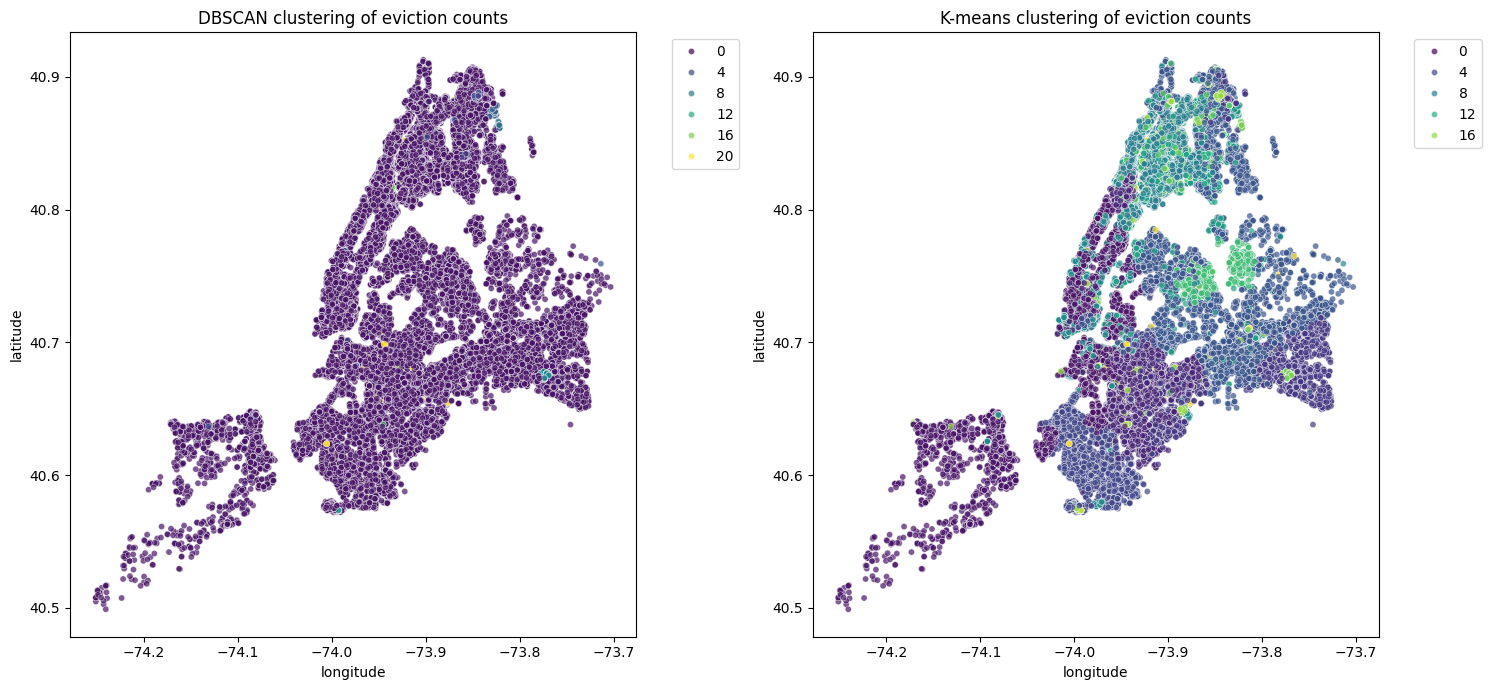

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

sns.scatterplot(x='longitude', y = 'latitude', hue = 'cluster', data = evictions_pre_post,
                s = 20, palette='viridis', alpha = 0.7, ax = ax1)

ax1.set_title('DBSCAN clustering of eviction counts')
ax1.legend(bbox_to_anchor=(1.05, 1), loc= 'upper left')

sns.scatterplot(x='longitude', y = 'latitude', hue = 'cluster_kmeans', data = evictions_pre_post,
                s = 20, palette='viridis', alpha = 0.7, ax = ax2)

ax2.set_title('K-means clustering of eviction counts')
ax2.legend(bbox_to_anchor=(1.05, 1), loc= 'upper left')
plt.tight_layout()
plt.show()

## **In short summary, with 20 clusters, it is clear that kmeans perform way better than DCSCAN, which is usually considered more appropriate than kmeans when it comes to geo data clustering.**
## Many inspirations are from but not limited to:

https://www.researchgate.net/post/Spatial_Clustering_DBSCAN_vs_Moran_I \
https://community.esri.com/t5/spatial-statistics-questions/moran-s-i-vs-incremental-spatial-autocorrelation/td-p/715710 \
https://mgimond.github.io/Spatial/spatial-autocorrelation.html \
https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/spatial-autocorrelation.html \
https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-how-can-i-detectaddress-spatial-autocorrelation-in-my-data/
https://crd230.github.io/lab7.html \
https://www.lehman.edu/media/School-of-Natural-and-Social-Sciences/EGGS-department/document/AnnMorris_GEP690FinalPresentation.pdf \

eviction related: https://pmc.ncbi.nlm.nih.gov/articles/PMC10696918/
https://www.sciencedirect.com/science/article/abs/pii/S0264275116300671
https://hex.tech/blog/comparing-density-based-methods/ \

less geo (emphasis)based:
https://stackoverflow.com/questions/39248953/dbscan-clustering-with-additional-features  \
https://stackoverflow.com/questions/14854243/alternative-similarity-measure-in-dbscan \

In [ ]:
evictions_pre_post.to_csv('/content/drive/My Drive/X999/evictions_pre_post_covid_all_clusters.csv')
# evictions_covid.to_csv('/content/drive/My Drive/X999/evictions_covid_clusters.csv')